# Neural network training tricks

From [fast.ai](https://course.fast.ai/) course.

CIFAR10 image classification

## Configuration

Imports

In [0]:
import numpy as np
from itertools import islice
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

Configuration

In [0]:
NUM_CLASSES = 10

In [0]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Dataset

In [0]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])
# train_transform = transforms.ToTensor()

In [0]:
train_dset = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root='.', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=128, shuffle=False, num_workers=4)


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [0]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

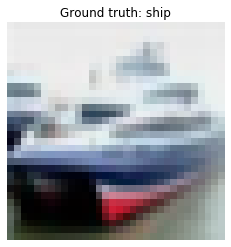

In [0]:
dataset_show_image(test_dset, 1)

## Model

Improvements of ResNet from [arXiv:1812.01187 [cs.CV]](https://arxiv.org/abs/1812.01187).

In [0]:
def init_linear(m):
    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    if m.bias is not None: nn.init.zeros_(m.bias)

In [0]:
class ConvBlock(nn.Sequential):
    def __init__(self, filters1, filters2, kernel_size, stride=1, include_relu=True, zero_bn=False):
        self.zero_bn = zero_bn
        padding = (kernel_size - 1) // 2
        layers = [nn.Conv2d(filters1, filters2, kernel_size, stride=stride, padding=padding, bias=False),
                  nn.BatchNorm2d(filters2)]
        if include_relu:
            layers.append(nn.ReLU(inplace=True))
        
        super().__init__(*layers)
    
    def reset_parameters(self):
        init_linear(self[0])
        self[1].reset_parameters()
        if self.zero_bn:
            nn.init.zeros_(self[1].weight)

In [0]:
class ResnetBlock(nn.Module):
    def __init__(self, prev_filters, filters, stride=1, bottleneck=True):
        super().__init__()
        
        if bottleneck:
            self.residual = self.bottleneck_residual(prev_filters, filters, stride)
        else:
            self.residual = self.basic_residual(prev_filters, filters, stride)
        
        if stride == 1:
            self.shortcut = lambda x: x
        else:
            self.shortcut = nn.Sequential(
                nn.AvgPool2d(stride),
                ConvBlock(prev_filters, filters, 1, include_relu=False)
            )
    
    def basic_residual(self, prev_filters, filters, stride):
        return nn.Sequential(
            ConvBlock(prev_filters, filters, 3, stride=stride),
            ConvBlock(filters, filters, 3, include_relu=False, zero_bn=True)
        )
    
    def bottleneck_residual(self, prev_filters, filters, stride):
        bottleneck_filters = filters // 4
        return nn.Sequential(
            ConvBlock(prev_filters, bottleneck_filters, 1),
            ConvBlock(bottleneck_filters, bottleneck_filters, 3, stride=stride),
            ConvBlock(bottleneck_filters, filters, 1, include_relu=False, zero_bn=True)
        )

    def forward(self, x):
        out = self.residual(x) + self.shortcut(x)
        out = F.relu(out, inplace=True)
        return out

In [0]:
class ResNet(nn.Sequential):
    def __init__(self, repetitions, classes, bottleneck=True):
        super().__init__()
        
        layers = [ConvBlock(3, 32, 3, stride=2),
                  ConvBlock(32, 32, 3),
                  ConvBlock(32, 64, 3)]
        
        prev_filters = 64
        init_filters = 256 if bottleneck else 64
        for stage, rep in enumerate(repetitions):
            filters = init_filters * (2**stage)
            stride = 2
            for _ in range(rep):
                layers.append(ResnetBlock(prev_filters, filters, stride, bottleneck))
                prev_filters = filters
                stride = 1
        
        layers += [nn.AdaptiveAvgPool2d(1),
                   nn.Flatten(),
                   nn.Linear(prev_filters, classes)]
        
        super().__init__(*layers)
        self.reset_parameters()
        
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, ConvBlock) or isinstance(m, nn.Linear):
                m.reset_parameters()

In [0]:
model = ResNet([2, 2, 2, 2], NUM_CLASSES, bottleneck=False).to(DEVICE) # ResNet18
# model = ResNet([3, 4, 6, 3], NUM_CLASSES, bottleneck=False).to(DEVICE) # ResNet34
# model = ResNet([3, 4, 6, 3], NUM_CLASSES, bottleneck=True).to(DEVICE) # ResNet50

## Loss

Label-smoothing regularization, [arXiv:1512.00567 [cs.CV]](https://arxiv.org/abs/1512.00567).

$$
\mathcal{L} = (1-\varepsilon) \mathrm{CE}(y) + \frac{\varepsilon}{N}\sum_{j=1}^N \mathrm{CE}(j)
$$

In [0]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [0]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε=0.1, reduction='mean'):
        super().__init__()
        self.ε = ε
        self.reduction = reduction
    
    def forward(self, output, target):
        c = output.size(-1)
        log_preds = F.log_softmax(output, dim=-1)
        loss1 = reduce_loss(-log_preds.sum(dim=-1) / c, self.reduction)
        loss2 = F.nll_loss(log_preds, target, reduction=self.reduction)
        loss = (1. - self.ε) * loss2 + self.ε * loss1
        return loss

## Mixup

Mixup augmentation, [arXiv:1710.09412 [cs.LG]](https://arxiv.org/abs/1710.09412).

Mixing parameter $\lambda$ is a random variable with Beta probability distribution
$$
\lambda\sim\mathrm{Beta}(\alpha, \alpha)
$$
The probability density function is
$$
P(\lambda;\alpha)=\frac{\Gamma(2\alpha)}{\Gamma(\alpha)^2}x^{\alpha-1}(1-x)^{\alpha-1}
$$

In [0]:
def plot_beta_pdf(α):
    x = np.linspace(0.01, 0.99)
    m = math.gamma(2 * α) / math.gamma(α)**2
    y = m * x**(α - 1) * (1. - x)**(α - 1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y)
    ax.set_xlabel('λ')
    ax.set_ylabel('P(λ)')
    plt.show()

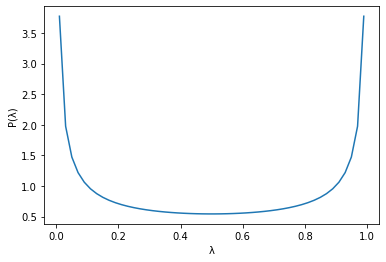

In [0]:
plot_beta_pdf(0.4)

In [0]:
class MixUp:
    def __init__(self, loss, α=0.4):
        self.distrib = torch.distributions.beta.Beta(α, α)
        self.loss = loss
    

    def process_batch(self, x):
        batch_size = x.size(0)
        λ = self.distrib.sample([batch_size]).to(DEVICE)
        self.λ = torch.stack([λ, 1. - λ], 1).max(1)[0] #remove equivalent λ values

        self.index = torch.randperm(batch_size).to(DEVICE)

        λ_x = self.λ.view(-1, 1, 1, 1)
        mixed_x = λ_x * x + (1. - λ_x) * x[self.index]
        return mixed_x
    

    def mixup_loss(self, pred, y):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, y) + (1. - self.λ) * self.loss(pred, y[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)
    

    def count_correct(self, pred, y):
        correct = self.λ * (pred == y).float() + (1. - self.λ) * (pred == y[self.index]).float()
        return correct.sum()

## Learner

In [0]:
class Accuracy:
    def __init__(self, counter=None):
        self.num_samples = 0
        self.num_correct = 0
        self.counter = counter if counter else self
    
    def count_correct(self, pred, y):
        return (pred == y).float().sum()
    
    def process_prediction(self, Y_pred, Y):
        batch_size = Y.size(0)
        labels_pred = torch.argmax(Y_pred, -1)
        self.num_correct += self.counter.count_correct(labels_pred, Y)
        self.num_samples += batch_size
    
    def get_average(self):
        return self.num_correct / self.num_samples

In [0]:
class AverageLoss:
    def __init__(self):
        self.total_loss = 0.0
        self.num_samples = 0
    
    def process_loss(self, batch_size, batch_loss):
        self.total_loss += batch_size * batch_loss
        self.num_samples += batch_size
    
    def get_average(self):
        return self.total_loss / self.num_samples

In [0]:
class AccumulateSmoothLoss:
    def __init__(self, smooth_f=0.05, diverge_th=5):
        self.diverge_th = diverge_th
        self.smooth_f = smooth_f
        self.losses = []
    
    def process_loss(self, batch_size, loss):
        if not self.losses:
            self.best_loss = loss
        else:
            if self.smooth_f > 0:
                loss = self.smooth_f * loss + (1. - self.smooth_f) * self.losses[-1]
            if loss < self.best_loss:
                self.best_loss = loss
        
        self.losses.append(loss)
        if loss > self.diverge_th * self.best_loss:
            raise StopIteration
    
    def get_losses(self):
        return self.losses

In [0]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader,
                 epoch_scheduler=None, batch_scheduler=None, mixup=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epoch_scheduler = epoch_scheduler
        self.batch_scheduler = batch_scheduler
        self.mixup = mixup
        self.reset_history()
    
    
    def reset_history(self):
        self.train_losses = []
        self.val_losses = []
        self.lrs = []
    

    def plot_losses(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        epochs = np.arange(1, len(self.train_losses)+1)
        ax.plot(epochs, self.train_losses, '.-', label='train')
        ax.plot(epochs, self.val_losses, '.-', label='val')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
        plt.show()
    

    def iterate(self, loader, cbs=[], backward_pass=False):
        for X, Y in loader:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            for cb in cbs:
                if hasattr(cb, 'process_batch'): X = cb.process_batch(X)
            
            Y_pred = self.model(X)
            batch_loss = self.loss(Y_pred, Y)
            if backward_pass: self.backward_pass(batch_loss)
            
            for cb in cbs:
                if hasattr(cb, 'process_loss'): cb.process_loss(X.size(0), batch_loss.item())
                if hasattr(cb, 'process_prediction'): cb.process_prediction(Y_pred, Y)
    

    def backward_pass(self, batch_loss):
        self.optimizer.zero_grad()
        batch_loss.backward()
        self.optimizer.step()
        
        if self.batch_scheduler:
            self.lrs.append(self.batch_scheduler.get_last_lr()[0])
            self.batch_scheduler.step()
    

    def train_for_epoch(self):
        self.model.train()
        
        if self.mixup: self.loss = self.mixup.mixup_loss    
        cbs = [AverageLoss(), Accuracy(self.mixup), self.mixup]
        self.iterate(self.train_loader, cbs, backward_pass=True)
        if self.mixup: self.loss = self.mixup.loss
        
        train_loss, train_acc = [cb.get_average() for cb in cbs[:2]]
        self.train_losses.append(train_loss)
        print(f'train loss {train_loss:.3f}, train accuracy {train_acc:.3f},', end=' ')
    

    def eval_on_validation(self):
        self.model.eval()
        
        cbs = [AverageLoss(), Accuracy()]
        with torch.no_grad():
            self.iterate(self.val_loader, cbs)
        
        val_loss, val_acc = [cb.get_average() for cb in cbs]
        self.val_losses.append(val_loss)
        print(f'val loss {val_loss:.3f}, val accuracy {val_acc:.3f}')
    
    
    def plot_lr_find(self, skip_start=10, skip_end=5):
        def split_list(vals, skip_start, skip_end):
            return vals[skip_start:-skip_end] if skip_end > 0 else vals[skip_start:]
        
        lrs = split_list(self.lrs, skip_start, skip_end)
        losses = split_list(self.train_losses, skip_start, skip_end)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(lrs, losses, '.-')
        ax.set_xscale('log')
        ax.set_xlabel('Learning rate')
        ax.set_ylabel('Loss')
        plt.show()
    
    
    def set_learning_rate(self, lr):
        new_lrs = [lr] * len(self.optimizer.param_groups)
        for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
            param_group["lr"] = new_lr
    
    
    def lr_find(self, start_lr, end_lr, num_iter):
        model_state = copy.deepcopy(self.model.state_dict())
        optimizer_state = copy.deepcopy(self.optimizer.state_dict())
        
        self.model.train()
        self.set_learning_rate(start_lr)

        gamma = (end_lr / start_lr)**(1 / num_iter)
        self.batch_scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma)
        
        if self.mixup: self.loss = self.mixup.mixup_loss
        cbs = [AccumulateSmoothLoss(), self.mixup]
        try:
            self.iterate(islice(self.train_loader, num_iter), cbs, backward_pass=True)
        except StopIteration:
            print("Stopping early, the loss has diverged")
        if self.mixup: self.loss = self.mixup.loss
        self.batch_scheduler = None
        
        self.model.load_state_dict(model_state)
        self.optimizer.load_state_dict(optimizer_state)
        
        self.train_losses = cbs[0].get_losses()
        self.plot_lr_find()
        self.reset_history()
    

    def fit(self, epochs):
        for i in range(epochs):
            print(f'{i+1}/{epochs}:', end=' ')
            self.train_for_epoch()
            self.eval_on_validation()
            
            if self.epoch_scheduler:
                self.lrs.append(self.epoch_scheduler.get_last_lr()[0])
                self.epoch_scheduler.step()

In [0]:
def plot_lrs(lrs):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    batches = np.arange(1, len(lrs)+1)
    ax.plot(batches, lrs)
    ax.set_xlabel('batch')
    ax.set_ylabel('lr')
    plt.show()

## Training

In [0]:
model.reset_parameters()

In [0]:
loss = LabelSmoothingCrossEntropy()
# loss = nn.CrossEntropyLoss()

AdamW optimizer: [arXiv:1711.05101 [cs.LG]](https://arxiv.org/abs/1711.05101). Implemented in PyTorch: [torch.optim.AdamW](https://pytorch.org/docs/stable/optim.html#torch.optim.AdamW)

In [0]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [0]:
mixup = MixUp(loss)
# mixup = None

In [0]:
learner = Learner(model, loss, optimizer, train_loader, test_loader, mixup=mixup)

Learning rate finder, from [arXiv:1506.01186 [cs.CV]](https://arxiv.org/abs/1506.01186).

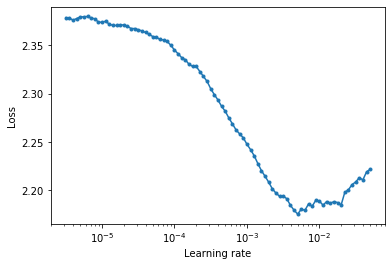

In [0]:
learner.lr_find(1e-6, 1e-1, num_iter=100)

In [0]:
EPOCHS = 12

"1cycle" leraning rate policy, [arXiv:1803.09820 [cs.LG]](https://arxiv.org/abs/1803.09820). Implemented in PyTorch: [torch.optim.lr_scheduler.OneCycleLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR).

In [0]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [0]:
learner.batch_scheduler = scheduler

In [0]:
learner.fit(EPOCHS)

1/12: train loss 1.925, train accuracy 0.348, val loss 1.669, val accuracy 0.461
2/12: train loss 1.728, train accuracy 0.461, val loss 1.562, val accuracy 0.549
3/12: train loss 1.603, train accuracy 0.528, val loss 1.534, val accuracy 0.528
4/12: train loss 1.529, train accuracy 0.571, val loss 1.231, val accuracy 0.679
5/12: train loss 1.462, train accuracy 0.603, val loss 1.192, val accuracy 0.699
6/12: train loss 1.416, train accuracy 0.627, val loss 1.105, val accuracy 0.739
7/12: train loss 1.371, train accuracy 0.649, val loss 1.038, val accuracy 0.772
8/12: train loss 1.327, train accuracy 0.669, val loss 0.951, val accuracy 0.808
9/12: train loss 1.289, train accuracy 0.687, val loss 0.918, val accuracy 0.821
10/12: train loss 1.253, train accuracy 0.703, val loss 0.869, val accuracy 0.848
11/12: train loss 1.227, train accuracy 0.716, val loss 0.853, val accuracy 0.854
12/12: train loss 1.212, train accuracy 0.722, val loss 0.844, val accuracy 0.858


ResNet50 reaches 92% accuracy after 50 epochs.

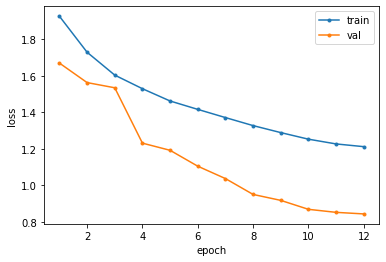

In [0]:
learner.plot_losses()

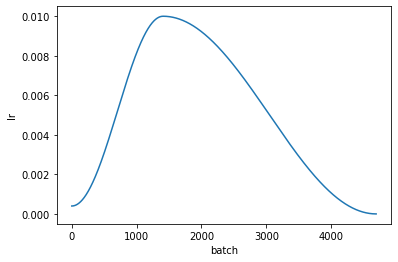

In [0]:
plot_lrs(learner.lrs)

## Testing

In [0]:
def find_failed(model, dset):
    model.eval()
    with torch.no_grad():
        for num, (X, Y) in enumerate(dset):
            Y_pred = model(X.unsqueeze(0).to(DEVICE))
            labels_pred = torch.argmax(Y_pred, -1)
            if labels_pred != Y:
                return num

In [0]:
num = find_failed(model, test_dset)
num

24

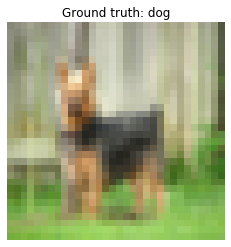

In [0]:
dataset_show_image(test_dset, num)

In [0]:
X_test, Y_test = test_dset[num]

In [0]:
Y_pred = model(X_test.unsqueeze(0).to(DEVICE))

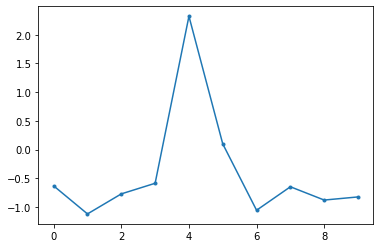

In [0]:
plt.plot(Y_pred.squeeze().detach().cpu(), '.-');

In [0]:
test_dset.classes[4]

'deer'